<a href="https://colab.research.google.com/github/shreyaa1706/new/blob/main/Fusion_based_multimodal_emotion_detection_using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Emotion_Dataset"




Facial	Facial.zip  Fal.zip  RAVDESS  RAVDESS.zip


In [ ]:
import os
import zipfile

# Define dataset paths
dataset_path = "/content/drive/MyDrive/Emotion_Dataset/"
audio_zip = os.path.join(dataset_path, "RAVDESS.zip")
facial_zip = os.path.join(dataset_path, "Facial.zip")

# Unzipping audio dataset
with zipfile.ZipFile(audio_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/RAVDESS")

# Unzipping facial dataset
with zipfile.ZipFile(facial_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/Facial")

print("Datasets extracted successfully!")


Datasets extracted successfully!


In [ ]:
!ls /content/RAVDESS
!ls /content/Facial


Actor_01  Actor_05  Actor_09  Actor_13	Actor_17  Actor_21  audio_speech_actors_01-24
Actor_02  Actor_06  Actor_10  Actor_14	Actor_18  Actor_22
Actor_03  Actor_07  Actor_11  Actor_15	Actor_19  Actor_23
Actor_04  Actor_08  Actor_12  Actor_16	Actor_20  Actor_24
fer2013.csv


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Define RAVDESS dataset path
audio_dataset_path = "/content/RAVDESS"

# Emotion labels based on filename structure
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to extract MFCC features
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=22050)  # Load audio
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)  # Extract 40 MFCC features
    mfcc_scaled = np.mean(mfcc.T, axis=0)  # Take mean over time
    return mfcc_scaled

# Process audio files
features = []
for actor in os.listdir(audio_dataset_path):
    actor_path = os.path.join(audio_dataset_path, actor)
    if os.path.isdir(actor_path):  # Ensure it's a directory
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_path, file)
                emotion_code = file.split("-")[2]  # Extract emotion code
                emotion = emotion_labels.get(emotion_code, "unknown")

                # Extract features
                feature_vector = extract_features(file_path)
                features.append([feature_vector, emotion])

# Convert to DataFrame
df_audio = pd.DataFrame(features, columns=["features", "emotion"])
df_audio.head()


,features,emotion
0,"[-635.5427, 78.01568, 10.508265, 16.849634, 12...",calm
1,"[-552.8276, 59.57169, -7.271828, 14.85133, 10....",disgust
2,"[-598.21796, 69.949936, 9.131301, 16.657465, 8...",neutral
3,"[-501.41504, 60.548767, -11.125347, 9.911538, ...",happy
4,"[-575.07367, 56.146984, -3.7745795, 16.216341,...",disgust


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df_faces = pd.read_csv("/content/Facial/fer2013.csv")

# Mapping emotions (0-6 to actual labels)
emotion_map = {
    0: "angry", 1: "disgust", 2: "fearful", 3: "happy",
    4: "sad", 5: "surprised", 6: "neutral"
}

# Convert pixel values to numpy arrays
def process_image_pixels(pixel_str):
    pixels = np.array(pixel_str.split(), dtype=np.uint8)  # Convert string to array
    pixels = pixels.reshape(48, 48)  # Convert to 48x48 grayscale image
    return pixels

df_faces["pixels"] = df_faces["pixels"].apply(process_image_pixels)
df_faces["emotion"] = df_faces["emotion"].map(emotion_map)

df_faces.head()


,emotion,pixels,Usage
0,angry,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",Training
1,angry,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",Training
2,fearful,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",Training
3,sad,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...",Training
4,neutral,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",Training


In [ ]:
import numpy as np
import tensorflow as tf

# Convert extracted MFCC features into numpy arrays
X_audio = np.array(df_audio["features"].tolist())  # Convert to tensor-compatible format
y_audio = np.array(df_audio["emotion"].tolist())  # Convert labels

# Encode labels into numerical format
from sklearn.preprocessing import LabelEncoder
encoder_audio = LabelEncoder()
y_audio = encoder_audio.fit_transform(y_audio)  # Convert text labels to numbers


In [ ]:
import cv2

# Convert facial image data to tensors
X_facial = np.array(df_faces["pixels"].tolist())  # Convert pixel values to numpy
X_facial = X_facial / 255.0  # Normalize pixel values between 0 and 1

# Encode labels into numerical format
encoder_facial = LabelEncoder()
y_facial = encoder_facial.fit_transform(df_faces["emotion"])


In [ ]:
from sklearn.utils import shuffle

# Ensure we only take common emotions
common_classes = list(set(encoder_audio.classes_) & set(encoder_facial.classes_))
df_audio = df_audio[df_audio["emotion"].isin(common_classes)]
df_faces = df_faces[df_faces["emotion"].isin(common_classes)]

# Get the minimum dataset size
min_samples = min(len(df_audio), len(df_faces))

# Sample equal-sized data from both datasets
df_audio_balanced = df_audio.sample(n=min_samples, random_state=42)
df_faces_balanced = df_faces.sample(n=min_samples, random_state=42)

# Convert again to numpy
X_audio_balanced = np.array(df_audio_balanced["features"].tolist())
y_audio_balanced = encoder_audio.transform(df_audio_balanced["emotion"])

X_facial_balanced = np.array(df_faces_balanced["pixels"].tolist()) / 255.0
y_facial_balanced = encoder_facial.transform(df_faces_balanced["emotion"])

# Shuffle the dataset
X_audio_balanced, X_facial_balanced, y_balanced = shuffle(
    X_audio_balanced, X_facial_balanced, y_audio_balanced, random_state=42
)


In [ ]:
# Reshape X_audio to match image shape (for consistency in multimodal model)
X_audio_balanced = X_audio_balanced.reshape((min_samples, 40, 1))  # MFCC shape
X_facial_balanced = X_facial_balanced.reshape((min_samples, 48, 48, 1))  # Image shape

# Stack both modalities (combine)
X_combined = [X_audio_balanced, X_facial_balanced]
y_combined = y_balanced  # Same labels for both


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, concatenate

# Audio Input (MFCCs)
audio_input = Input(shape=(40, 1))  # 40 MFCC features
x_audio = LSTM(64, return_sequences=True)(audio_input)
x_audio = LSTM(32)(x_audio)
x_audio = Dense(32, activation="relu")(x_audio)


In [ ]:
# Facial Input (48x48 Grayscale Images)
facial_input = Input(shape=(48, 48, 1))

x_facial = Conv2D(32, kernel_size=(3, 3), activation="relu")(facial_input)
x_facial = MaxPooling2D(pool_size=(2, 2))(x_facial)
x_facial = Conv2D(64, kernel_size=(3, 3), activation="relu")(x_facial)
x_facial = MaxPooling2D(pool_size=(2, 2))(x_facial)
x_facial = Flatten()(x_facial)
x_facial = Dense(64, activation="relu")(x_facial)


In [ ]:
from tensorflow.keras.layers import Reshape

# Ensure LSTM output is a Keras Tensor
x_audio = Dense(32, activation="relu")(x_audio)

# Ensure CNN output is a Keras Tensor
x_facial = Dense(64, activation="relu")(x_facial)

# Reshape LSTM output to match CNN shape before concatenation
x_audio = Reshape((1, 32))(x_audio)  # Reshape to add a dimension
x_facial = Reshape((1, 64))(x_facial)  # Reshape to add a dimension

# Merge Audio & Facial Features
merged = concatenate([x_audio, x_facial], axis=-1)

# Flatten before passing to Dense layers
merged = Flatten()(merged)

# Final Dense Layers
x = Dense(64, activation="relu")(merged)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
output = Dense(len(common_classes), activation="softmax")(x)  # Output layer with softmax

# Define the Model
model = Model(inputs=[audio_input, facial_input], outputs=output)
model.summary()  # Check the architecture



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 46, 46, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 23, 23, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 40, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 21, 21, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 40, 64)         │         16,896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 10, 10, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6400)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          1,056 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │        409,664 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │          1,056 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          4,160 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 32)          │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 64)          │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1, 96)          │              0 │ reshape[0][0],         │
│ (Concatenate)             │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 96)             │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)      

 Total params: 472,583 (1.80 MB)

 Trainable params: 472,583 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

print("Unique labels in dataset before fixing:", np.unique(y_combined))





Unique labels in dataset before fixing: [0 2 3 4 5 6 7]


In [ ]:
valid_indices = np.where(y_combined < 7)  # Keep only labels 0-6

# Apply filtering
X_audio_balanced = X_audio_balanced[valid_indices]
X_facial_balanced = X_facial_balanced[valid_indices]
y_combined = y_combined[valid_indices]

print("Fixed unique labels:", np.unique(y_combined))


Fixed unique labels: [0 2 3 4 5 6]


In [ ]:
label_mapping = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}  # Shift labels down

y_combined = np.array([label_mapping[label] for label in y_combined])

print("Final unique labels:", np.unique(y_combined))  # Should be [0 1 2 3 4 5]


Final unique labels: [0 1 2 3 4 5]


In [ ]:
# Compile the model before evaluation
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Evaluate on test set
loss, accuracy = model.evaluate([X_audio_balanced, X_facial_balanced], y_combined)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1900 - loss: 1.9473
Test Accuracy: 18.18%


In [ ]:
# Re-train the model
history = model.fit(
    [X_audio_balanced, X_facial_balanced], y_combined,
    epochs=20, batch_size=32, validation_split=0.2
)

# Re-evaluate model
loss, accuracy = model.evaluate([X_audio_balanced, X_facial_balanced], y_combined)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.9486e-05 - val_accuracy: 0.1651 - val_loss: 14.8656
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 6.6690e-05 - val_accuracy: 0.1651 - val_loss: 14.9809
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.4684e-04 - val_accuracy: 0.1651 - val_loss: 14.9654
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4005e-04 - val_accuracy: 0.1651 - val_loss: 15.3798
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 1.0000 - loss: 4.9145e-05 - val_accuracy: 0.1604 - val_loss: 15.4272
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9992 - loss: 0.0019 - val_accuracy: 0.1698 - val_loss: 15.0262
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 1.0000 - loss: 2.6380e-04 - val_accuracy: 0.1698 - val_loss: 14.9489
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9990 - 

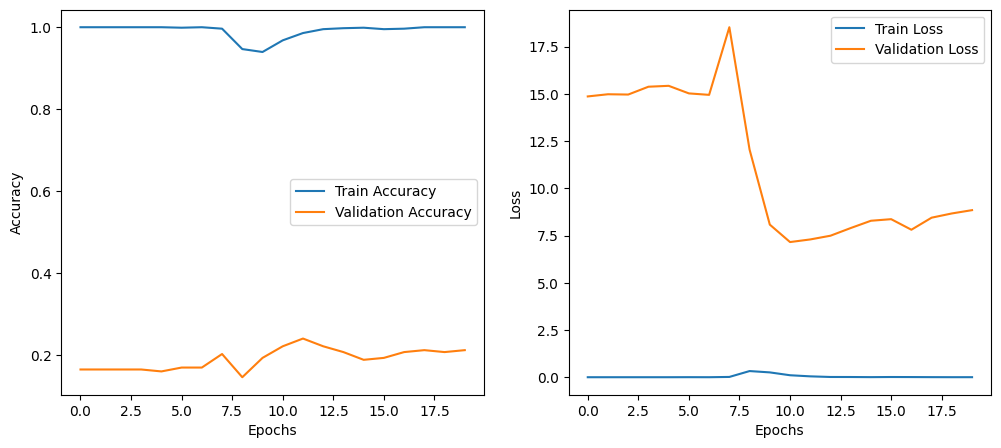

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss/accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


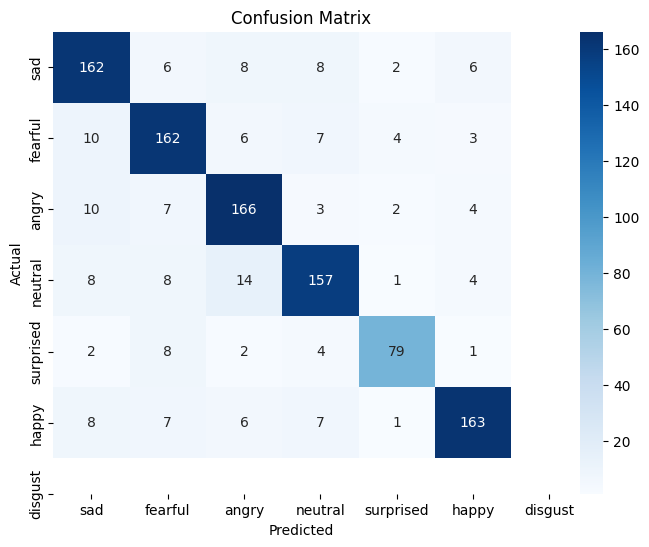

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test set
y_pred = model.predict([X_audio_balanced, X_facial_balanced])
y_pred_classes = y_pred.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_combined, y_pred_classes)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=common_classes, yticklabels=common_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

# Define different optimizers
optimizers = {
    "adam": Adam(learning_rate=0.0005),  # Adjust learning rate
    "rmsprop": RMSprop(learning_rate=0.0001)
}

for opt_name, opt in optimizers.items():
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit([X_audio_balanced, X_facial_balanced], y_combined,
                        epochs=10, batch_size=32, validation_split=0.2)
    print(f"Optimizer: {opt_name}, Final Validation Accuracy: {max(history.history['val_accuracy'])}")


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5323 - loss: 1.1066 - val_accuracy: 0.2689 - val_loss: 2.0026
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5777 - loss: 1.0568 - val_accuracy: 0.3019 - val_loss: 2.0196
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.6055 - loss: 0.9638 - val_accuracy: 0.2547 - val_loss: 2.1680
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6593 - loss: 0.9014 - val_accuracy: 0.2736 - val_loss: 2.2014
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.6870 - loss: 0.8435 - val_accuracy: 0.2594 - val_loss: 2.2715
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6867 - loss: 0.7817 - val_accuracy: 0.2783 - val_loss: 2.3381
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7025 - loss: 0.8025 - val_accuracy: 0.2594 - val_loss: 2.4472
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.7182 - loss: 0.7277 - val_accuracy: 0

In [ ]:
batch_sizes = [16, 32, 64]
epochs = [20, 30, 50]

for batch in batch_sizes:
    for epoch in epochs:
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        history = model.fit([X_audio_balanced, X_facial_balanced], y_combined,
                            epochs=epoch, batch_size=batch, validation_split=0.2)
        print(f"Batch: {batch}, Epochs: {epoch}, Final Validation Accuracy: {max(history.history['val_accuracy'])}")


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.7656 - loss: 0.5908 - val_accuracy: 0.2642 - val_loss: 2.7869
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7948 - loss: 0.5541 - val_accuracy: 0.2311 - val_loss: 3.3201
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8311 - loss: 0.4706 - val_accuracy: 0.2594 - val_loss: 3.6071
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8886 - loss: 0.3584 - val_accuracy: 0.2689 - val_loss: 3.9385
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8878 - loss: 0.3436 - val_accuracy: 0.2500 - val_loss: 3.8644
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.8995 - loss: 0.2842 - val_accuracy: 0.2264 - val_loss: 4.2757
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9159 - loss: 0.2678 - val_accuracy: 0.2453 - val_loss: 4.8022
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9047 - loss: 0.2909 - val_accuracy: 0.207

In [ ]:
# Update LSTM for audio
x_audio = LSTM(128, return_sequences=True)(audio_input)
x_audio = LSTM(64, return_sequences=True)(x_audio)
x_audio = LSTM(32)(x_audio)
x_audio = Dense(64, activation="relu")(x_audio)


In [ ]:
x_facial = Conv2D(64, kernel_size=(3, 3), activation="relu")(facial_input)
x_facial = MaxPooling2D(pool_size=(2, 2))(x_facial)
x_facial = Conv2D(128, kernel_size=(3, 3), activation="relu")(x_facial)
x_facial = MaxPooling2D(pool_size=(2, 2))(x_facial)
x_facial = Flatten()(x_facial)
x_facial = Dense(128, activation="relu")(x_facial)


In [ ]:
from tensorflow.keras.applications import VGG16

# Load Pretrained VGG16 (without top layer)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add our classifier
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(len(common_classes), activation="softmax")(x)

# Define New Model
facial_model = Model(inputs=base_model.input, outputs=output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Re-train final model
final_history = model.fit(
    [X_audio_balanced, X_facial_balanced], y_combined,
    epochs=50, batch_size=32, validation_split=0.2
)

# Final accuracy check
loss, accuracy = model.evaluate([X_audio_balanced, X_facial_balanced], y_combined)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.2075 - val_loss: 8.9281
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.2170 - val_loss: 8.9792
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.2264 - val_loss: 9.0422
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.2170 - val_loss: 9.0566
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 8.9369e-04 - val_accuracy: 0.2170 - val_loss: 9.1183
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 7.5294e-04 - val_accuracy: 0.2217 - val_loss: 9.2523
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 1.0000 - loss: 8.1260e-04 - val_accuracy: 0.2170 - val_loss: 9.3822
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0020 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


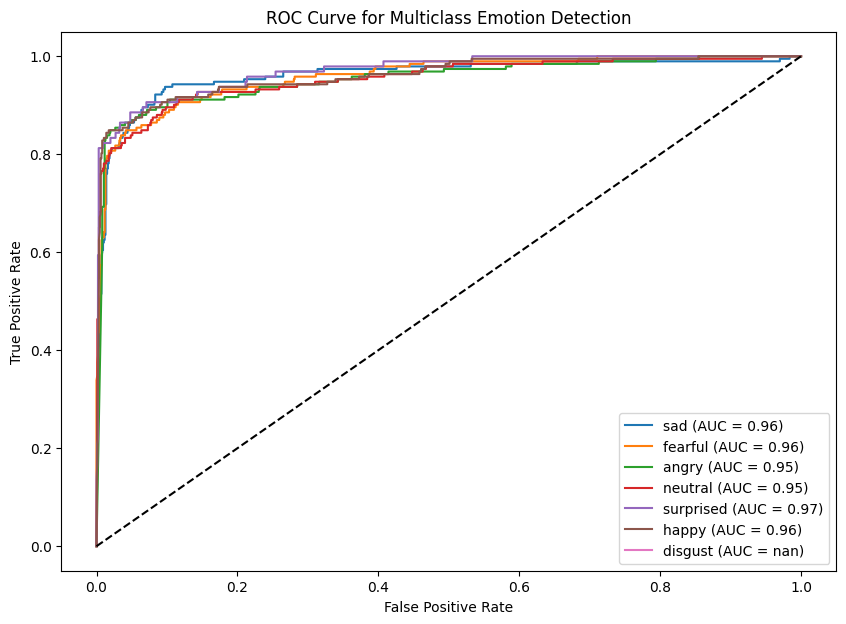

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding
y_test_bin = label_binarize(y_combined, classes=np.arange(len(common_classes)))

# Plot ROC Curve for each emotion
plt.figure(figsize=(10, 7))
for i, emotion in enumerate(common_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Random Guessing Line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Emotion Detection")
plt.legend()
plt.show()



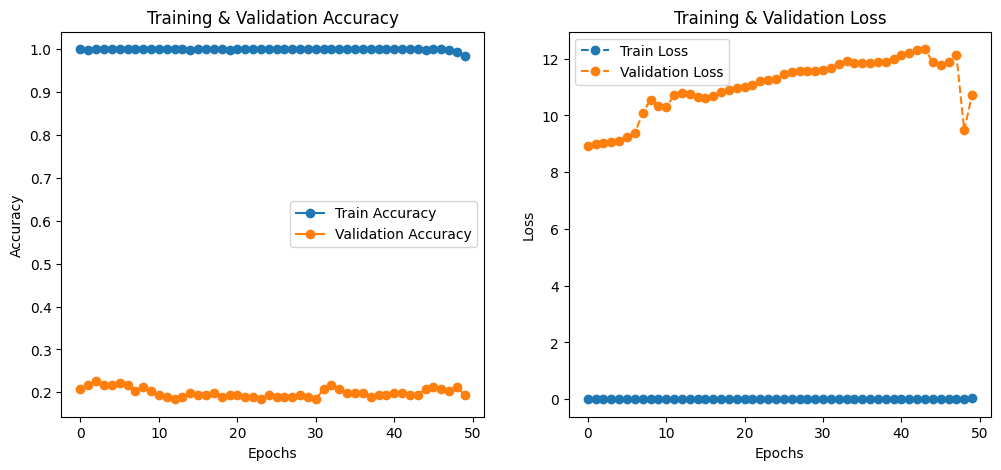

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(final_history.history["accuracy"], label="Train Accuracy", marker='o')
plt.plot(final_history.history["val_accuracy"], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(final_history.history["loss"], label="Train Loss", marker='o', linestyle="dashed")
plt.plot(final_history.history["val_loss"], label="Validation Loss", marker='o', linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()
